- CFD 결과를 바탕으로 최고의 Torque가 나오는 각도 배치 탐색
- 첨점을 없애기 위한 Smoothing Code와 그에 대한 Torque 계산 병행
- 물레방아와의 대조

## Preview : Half Capsule Flap (최고 성능) Smoothing GIF

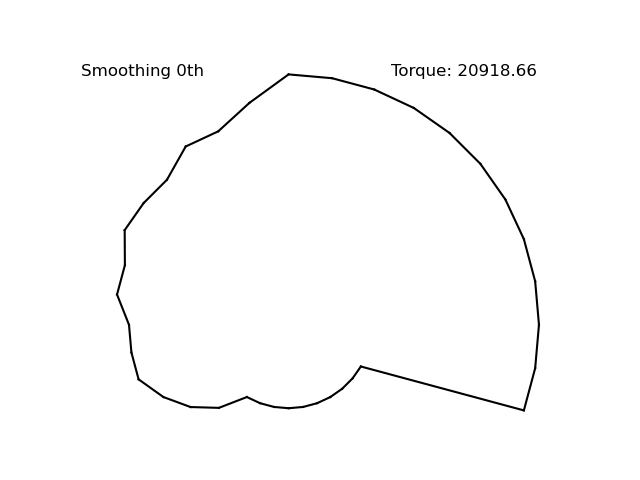

![날개 종류와 토크 합산변화.png](<attachment:날개 종류와 토크 합산변화.png>)
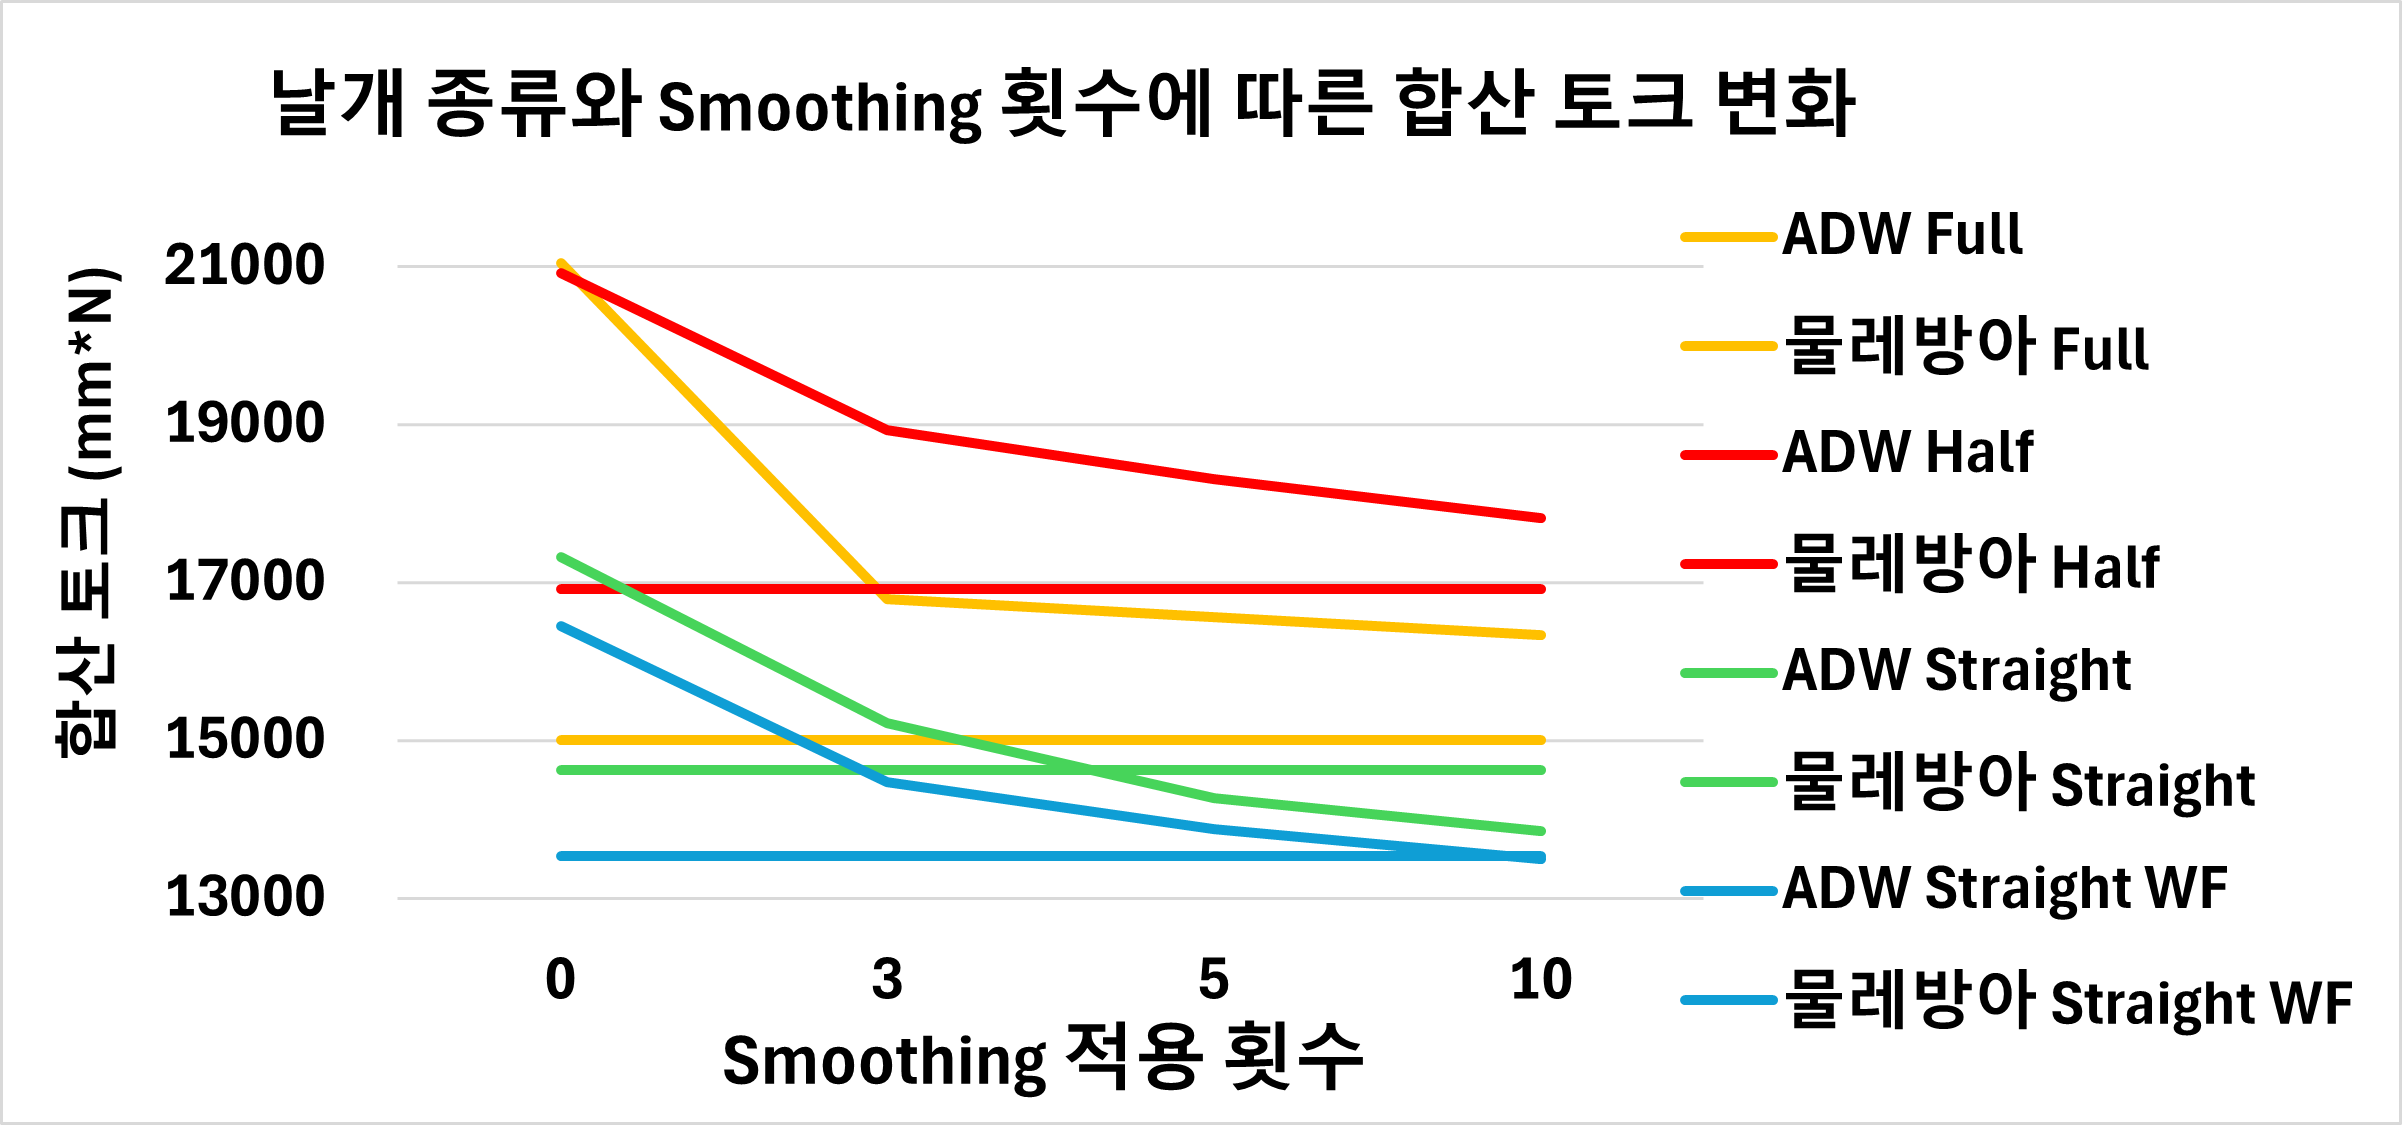

In [12]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import math
import ezdxf
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle

def read_excel_to_numpy():
    # Using tkinter to open a file dialog
    root = tk.Tk()
    root.withdraw()
    
    file_path = "C:/Users/user/OneDrive/문서/GitHub/LowFlowRateHydroTurbine/HSC2023 한화 사이언스 챌린지 대상/Analysis Data and Code/날개 종류 별 CFD 힘 분석 데이터 Raw.xlsx"

    #tkinter에서는 "Analysis Data\날개 종류 별 CFD 힘 분석 데이터 Raw.xlsx" 이 파일을 열면 됨
    # Check if a file was selected
    if not file_path:
        print("No file selected!")
        return

    # Using pandas to read the Excel file
    df = pd.read_excel(file_path, engine='openpyxl')

    # Transforming the pandas DataFrame into a numpy array
    data = df.to_numpy()

    return data

# Angleblock 최적화 및 Smoothing 함수들

def indexer(l, i):
    # 리스트의 순환 인덱싱을 위한 함수
    length = len(l)
    if i < 0: 
        i += length
    elif i >= length: 
        i -= length
    return l[i]

def smooth(l, i):
    # 3점 이동 평균을 계산하는 함수
    su = indexer(l, i-1) + indexer(l, i) + indexer(l, i+1)
    return su / 3

def smoothout(l, k):
    if (k ==0):
        return l
    # Smoothing 과정을 k번 반복하는 재귀 함수
    nex = []
    for index in range(len(l)):
        nex.append(smooth(l, index))
    if k == 0: 
        return nex
    return smoothout(nex, k-1)

def gettorque(phidist, dataset):
    # 주어진 각도 분포에 대한 총 토크를 계산하는 함수
    totaltorque = 0
    for i in range(36):
        theta = i * 10 
        phi = phidist[i]
        
        # delta 각도 계산
        delta = 270 - theta - phi
        if delta < 0:
            delta += 360
        if delta >= 360:
            delta -= 360

        delta = (delta // 10) * 10

        # CFD 데이터에서 해당 각도의 힘 데이터 찾기
        index = np.where(dataset[0] == delta)[0]
        fy = dataset[flapindex][index][0]
        fz = dataset[flapindex+1][index][0]

        # 토크 계산
        r1 = 60  # mm
        l = 90  # mm
        x = r1 * math.cos(math.radians(theta)) - l/2 * math.cos(math.radians(delta))
        y = r1 * math.sin(math.radians(theta)) + l/2 * math.sin(math.radians(delta))
        torque = x * fz + y * fy

        totaltorque += torque

    return totaltorque


def phitor(phidist):
    """
    phi 각도 분포를 Angleblock의 반지름 분포로 변환하는 함수
    
    :param phidist: phi 각도의 리스트 (36개의 10도 간격 값)
    :return: Angleblock의 반지름 리스트
    """
    r = []
    d = 30  # mm, Linear Axis Guide (LAG)의 이동 거리
    r1 = 60  # mm, 기본 반지름
    for phi in phidist:
        # phi 각도에 따른 Angleblock의 반지름 계산
        # 45도를 기준으로 tan 함수 사용 (45도일 때 LAG가 중립 위치)
        r.append(r1 + d * math.tan(math.radians(phi - 45)))
    return r

def r_to_dxf(radial_distances, output_file):
    """
    반지름 리스트를 사용하여 Angleblock의 DXF 파일을 생성하는 함수
    
    :param radial_distances: Angleblock의 반지름 리스트 (36개 값)
    :param output_file: 출력할 DXF 파일 이름
    """
    doc = ezdxf.new()  # 새 DXF 문서 생성
    msp = doc.modelspace()  # 모델 스페이스 접근

    num_points = len(radial_distances)
    if num_points != 36:
        raise ValueError("Expected 36 radial distances")

    points = []
    for k, distance in enumerate(radial_distances):
        # 각 지점의 x, y 좌표 계산 (극좌표계 -> 직교좌표계)
        angle_rad = math.radians(10 * k)  # 10도 간격으로 36개 지점
        x = distance * math.cos(angle_rad)
        y = distance * math.sin(angle_rad)
        points.append((x, y))

    # 각 지점을 연결하는 선 그리기
    for i in range(num_points):
        start_point = points[i]
        end_point = points[(i + 1) % num_points]  # 마지막 점은 첫 점과 연결
        msp.add_line(start_point, end_point)

    doc.saveas(output_file)  # DXF 파일로 저장



In [ ]:
"""
# dxf 제작 코드 사용 예제
if __name__ == "__main__":
# 예시 phi 각도 분포 (실제로는 최적화 과정에서 얻어진 값 사용)
example_phi_dist = [45] * 36  # 모든 각도를 45도로 가정 (예시)

# phi 각도를 Angleblock 반지름으로 변환
radial_distances = phitor(example_phi_dist)

# Angleblock DXF 파일 생성
r_to_dxf(radial_distances, "example_angleblock.dxf")"""

In [7]:
# Excel 파일에서 CFD 데이터 읽기
dataset = read_excel_to_numpy()
if dataset is not None:
    print("Data loaded successfully!")

flaptype = 'half' # full, half, straight, straightWF

flapdict = {'full' : 1, 'half' : 4, 'straight' : 7, 'straightWF' : 10} #dataset에 상응하는 Column을 대응시킴

flapindex = flapdict[flaptype]

Data loaded successfully!


In [8]:
# 각 날개 위치에 대한 최적 각도 찾기
thetaphi_raw_t = []
thetaphi_raw_p = []

print(dataset[flapindex][0])
print(dataset[flapindex+1][0])
# 수차의 한 회전(360도)에 대해 10도 간격으로 반복
for theta in range(0, 360, 10):
    torquemax = -10000000  # 최대 토크 초기화
    phimax = 0  # 최대 토크를 발생시키는 phi 각도 초기화
    
    # 각 theta에 대해 가능한 모든 phi 각도(0~90도)를 10도 간격으로 검사
    for phi in range(0, 90 + 1, 10):
        # delta 계산: 수평면(유속 방향)과 날개가 이루는 각도
        delta = 270 - theta - phi
        
        # delta를 0~359도 범위로 조정
        if delta < 0:
            delta += 360
        if delta >= 360:
            delta -= 360

        # CFD 데이터에서 현재 delta에 해당하는 힘 데이터의 인덱스 찾기
        index = np.where(dataset[0] == delta)[0]
        
        # 해당 delta에서의 y방향(유속 방향)과 z방향(수직 방향) 힘 추출
        fy = dataset[flapindex][index][0]
        fz = dataset[flapindex+1][index][0]

        # 날개의 기하학적 파라미터
        r1 = 60  # 수차 회전 반경 (mm)
        l = 90   # 날개 길이 (mm)

        # 날개에 작용하는 힘의 모멘트 암 계산
        # x: 수평 방향 모멘트 암, y: 수직 방향 모멘트 암
        x = r1 * math.cos(math.radians(theta)) - l/2 * math.cos(math.radians(delta))
        y = r1 * math.sin(math.radians(theta)) + l/2 * math.sin(math.radians(delta))

        # 현재 각도 조합에서의 토크 계산
        torque = x * fz + y * fy

        # 최대 토크와 그때의 phi 각도 업데이트
        if torque > torquemax:
            torquemax = torque
            phimax = phi

    # 현재 theta에 대한 최적 phi 각도 저장
    thetaphi_raw_p.append(phimax)
    thetaphi_raw_t.append(theta)

halfcapsuleflap fy
halfcapsuleflap fz


In [13]:
# Smoothing 적용 (p stands for phi), 각각 3회 5회 10회
sm3_p =smoothout(thetaphi_raw_p, 3)
sm5_p =smoothout(thetaphi_raw_p, 5)
sm10_p = smoothout(thetaphi_raw_p, 10)

# 각 Smoothing 결과에 대한 토크 계산 (t stands for torque)
raw_t = gettorque(thetaphi_raw_p, dataset)
sm3_t = gettorque(sm3_p, dataset)
sm5_t = gettorque(sm5_p, dataset)
sm10_t = gettorque(sm10_p, dataset)

print(raw_t, sm3_t, sm5_t, sm10_t, sep = '\t')

# r stands for radius/ Angleblock 형상을 정하는 함수
r_raw = phitor(thetaphi_raw_p)
r_sm3 = phitor(sm3_p)
r_sm5 = phitor(sm5_p)
r_sm10 = phitor(sm10_p)

#make dxf
#r_to_dxf(r_raw, "raw.dxf")
#r_to_dxf(r_sm3, "sm3.dxf")
#r_to_dxf(r_sm5, "sm5.dxf")
#r_to_dxf(r_sm10, "sm10.dxf")

for i in range (0, 11) : 
    phi_ = smoothout(thetaphi_raw_p, i)
    radius_ = phitor(phi_)
    r_to_dxf(radius_,"smoothing_" + str(i)+".dxf")
    _torque = gettorque(phi_, dataset)

    print(_torque)

20918.66318186131	19160.04288749457	18602.896043397453	17928.532960681725
20918.66318186131
20116.358519689795
19608.462673814127
19160.04288749457
18926.02272242396
18602.896043397453
18307.77628085697
17928.532960681725
17928.532960681725
17928.532960681725
17928.532960681725


In [ ]:
# 일반적인 물레방아 토크 구하기

totaltorque = 0
for i in range(18, 36): #180도에서 360까지, 물레방아의 절반만 잠겼다 가정하고 토크 계산

    theta = i * 10 #theta 자체는 날개가 유속과 이루는 각도이다

    if (theta < 0) :
        theta += 360
    phi = 90 # phi는 날개가 회전반경 접선과 이루는 각이다. 
    #90도이므로 반지름 벡터와 같은 방향 (중심에서 밖으로 나가는 방향으로 날개가 되어 있다는 뜻)
    #위 코드와 달리 물레방아의 경우 날개의 방향이 고정되어있기에 phi = 90으로 계산하였다.

    delta = 270-theta-phi 
    if(delta <0):
        delta +=360
        #print(delta)
    if (delta >=360):
        delta -= 360

    delta = (delta //10 )*10


    index = np.where(dataset[0] == delta)[0]
    fy = dataset[flapindex][index][0]
    fz = dataset[flapindex+1][index][0]

    r1 = 60 #mm
    l = 90 #mm

    x = r1 * math.cos(math.radians(theta)) - l/2 *math.cos(math.radians(delta))
    y = r1 * math.sin(math.radians(theta)) + l/2 *math.sin(math.radians(delta))

    torque = x*fz + y * fy


    totaltorque += torque

#0도에서 180도까지, 반대 방향으로 물레방아를 담궜을때의 토크 계산
print("ordinary wheel", totaltorque)

totaltorque = 0
for i in range(0, 18+1):

    theta = i * 10 

    if (theta < 0) :
        theta += 360
    phi = 90
    
    delta = 270-theta-phi
    if(delta <0):
        delta +=360
        #print(delta)
    if (delta >=360):
        delta -= 360

    delta = (delta //10 )*10


    index = np.where(dataset[0] == delta)[0]
    fy = dataset[flapindex][index][0]
    fz = dataset[flapindex+1][index][0]

    r1 = 60 #mm
    l = 90 #mm

    x = r1 * math.cos(math.radians(theta)) - l/2 *math.cos(math.radians(delta))
    y = r1 * math.sin(math.radians(theta)) + l/2 *math.sin(math.radians(delta))

    torque = x*fz + y * fy


    totaltorque += torque
print("ordinary wheel", totaltorque)
    
# 결과적으로 물레방아 데이터 두 개가 나오게 되는데, 이 둘 중에서 더 큰 값을 쓰면 된다.
# 그 의미는 날개 형상의 비대칭으로 인해 특정 방향의 회전에서 더 두드러지는 성능을 보인다는 것이다.